<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/cv04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. cvičenie - Plne prepojená sieť v PyTorchi

V tomto notebooku si vyskúšame trénovanie v kerase. Prejdeme si základ delenia dát na trénovacie, validačné a testovacie. Skontrolujeme účinky over a underfittingu. Otestujeme rôzne aktivačné funkcie a cenové funkcie. Otestujeme možnosti regularizácie.

Pri práci budeme používať framework PyTorch, ktorého dokumentáciu nájdete na https://pytorch.org/docs/stable/index.html

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

Budeme pracovať s jednoduchým datasetom MNIST, ktorý obsahuje obrázky čísel, ktoré sa vypĺňajú do PSČ políčok.

In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

x_np = mnist.data.to_numpy().astype('float32')/255
labels_np = mnist.target.to_numpy().astype('int64')

Dataset si môžeme zobraziť.

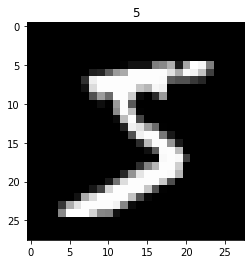

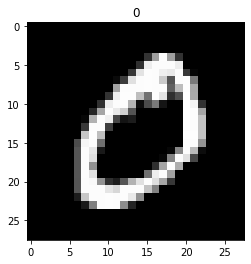

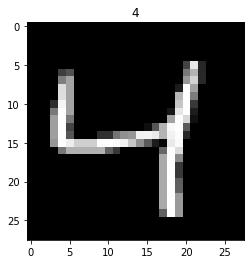

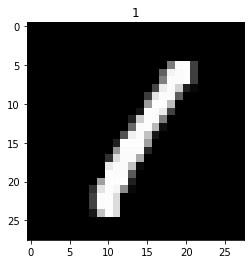

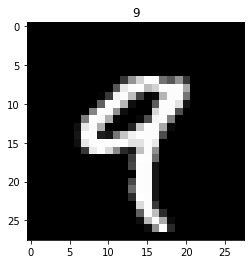

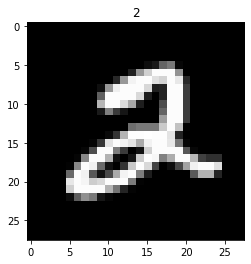

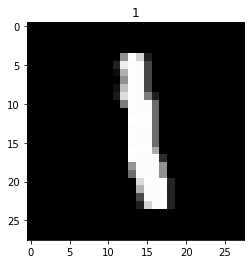

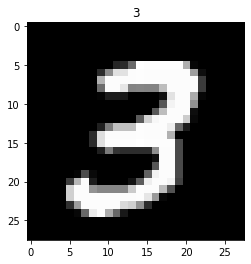

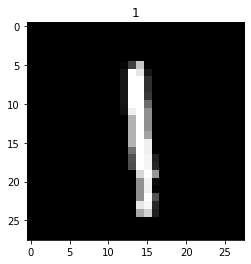

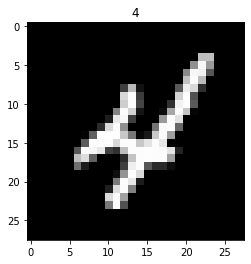

In [7]:
for i in range(10):
  plt.imshow(np.reshape(x_np[i,],(28,28)), cmap='gray')
  plt.title(labels_np[i])
  plt.show()

## One-hot encoding

Doteraz sme pracovali iba s dvoma triedami. V takom prípade bola reprezentácia relatívne jednoduchá. Avšak pri viac triedach je nutné zvoliť vhodný spôsob ako tieto triedy reprezentovať. Dalo by sa napr. to jedným číslom a to by sieť mala vyhodiť. Avšak to je problém, lebo napr. ak máme tri kategórie: mačka (0), pes (1), škrečok (2), tak by sa sieť v podstate musela naučiť reprezentáciu v ktorej platí, že priemer mačky a škrečka je pes, lebo (0 + 2) / 2 = 1. Toto nedáva zmysel. Preto bude lepšie ak sieť bude na výstupe mať napr. vektor s rovnakou dĺžkou ako počet tried a každý prvok bude určovať pravdepodobnosť danej triedy. Pri anotovaných dátach presne vieme, že len jedna kategória má pravdebodobnosť jedna a ostatné nula, takže bude vyzerať asi takto $(0, 0, 0, 1, 0, 0)$. Takáto reprezentácia sa volá one-hot encoding. Na konverziu labelov, môžeme použiť pytorchovskú funkciu onehot.

Keďže ďalej budeme pracovať s tenzormy, tak si prekonvertujeme aj naše vstupné dáta na torch Tensory pomocou torch.from_numpy(). Funkcia one_hot urobí konverziu automaticky.

In [8]:
from torch.nn.functional import one_hot

x = torch.from_numpy(x_np)

y = one_hot(torch.from_numpy(labels_np))

labels = torch.from_numpy(labels_np)

for i in range(10):
  print("labels: ", labels[i])
  print("one-hot: ", y[i])

labels:  tensor(5)
one-hot:  tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
labels:  tensor(0)
one-hot:  tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(4)
one-hot:  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(9)
one-hot:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
labels:  tensor(2)
one-hot:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(3)
one-hot:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
labels:  tensor(1)
one-hot:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
labels:  tensor(4)
one-hot:  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


## Model plne prepojenej siete

Najprv si teda vytvoríme model. Náš model nebude využívať komplikované prepojenia, takže môžeme použiť torch.nn.Sequential. Čo je konštruktor pre sieť v ktorej výstup z jednej vrstvy je vstupom iba do ďalšej atď.

Ako jednotlivý prvky v modeli budú jeho vrstvy. Tu použijeme plne prepojené vrstvy, ktoré sa v kerase dajú nájsť pod torch.nn.Linear. Podobne budeme podtrebovať aj aktivačné funkcie napr. torch.nn.ReLU. Jednolivé plneprepojené vrstvy sa inicializujú s argumentmi s počtom vstupných a výstupných neurónov. V prvej vrstve teda potrebujeme 28 * 28 neurónov (rovnako ako v obrázku) a na výstupe 10 podľa počtu tried.

### Stratová funkcia

Ako stratovú funkciu použijeme tzv. categorical crossentropy. Tá má tvar

$$L(\vec{y}, \hat{\vec{y}}) = - \sum_{i=1}^n \hat{\vec{y}}_i \text{log}(\vec{y}),$$

kde $\vec{y}$ je výstup siete a $\hat{\vec{y}}$ sú one-hot anotácie. Na to aby to fungovalo, tak predpokladáme, že posledná vrstva je tzv. softmax, ktorá aplikuje funkciu $\mathbb{R}^n \mapsto \mathbb{R}^n$ a pre vstupný vektor má jej $i$-tá zložka tvar:

$$\text{softmax}(\vec{z})_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}.$$

Táto vrstva teda akosi normalizuje výstupy siete tak, aby sme ich mohli interpretovať ako pravdepodobnosti, keďže jej výsupy sa dajú sčítať na 1. Problémom je, že táto vrstva robí operáciu exp, ale v stratovej funkcii zas robíme log. Ak aplikujeme exp na nejaké veľké číslo môžeme dostať NaN a následny logaritmus bude tiež nan, aj keď plátí že:

$$ \text{log}(e^X) = X,$$

teda sa dá NaNu vyhnúť. Preto budeme mať dva modely jeden bude pre trénovanie a nebude rovno sa v ňom spočíta loss zo vstupov do softmaxu a v druhom sa aplikuje len softmax.

Ako loss teda môžeme použiť torch.nn.CrossEntropyLoss.


### Optimalizácia

V minulosti sme používali optimalizáciu, ktorú sme si vyrobili ručne. Torch však ponúka aj túto funkcionalitu rovno naimplementovanú. Rôzne optimalizačné postupy sú k dispozícii v torch.optim

Zatiaľ použijeme torch.optim.SGD. Tomuto objektu ale treba aj dať vedieť, čo sú parametre modelu. Tie získame z už konštruovaného modelu.

In [9]:
from torch.nn import Sequential, Linear, ReLU, Softmax
model = Sequential(Linear(28 * 28, 30),
                   ReLU(),
                   Linear(30, 20),
                   ReLU(),
                   Linear(20, 10))

model_inference = Sequential(model, Softmax(dim=-1)) 

Model môžeme aplikovať na vstupné dáta. Pritom sa však očakáva, že vstup bude veľkosti $n \times (28*28)$. V jednoduchom prípade sieť zvládne aj vstup veľkosti $28 * 28$, ale netreba s tým rátať aj pri iných sieťach.

In [10]:
print(model_inference(x[:3]))
print(model_inference(x[0]))
print(model_inference(x[None, 0]))

print(model(x[:3]))
print(model(x[0]))
print(model(x[None, 0]))


tensor([[0.1143, 0.1310, 0.0862, 0.0944, 0.0858, 0.0908, 0.1196, 0.1157, 0.0837,
         0.0785],
        [0.1139, 0.1287, 0.0847, 0.0977, 0.0892, 0.0917, 0.1207, 0.1161, 0.0806,
         0.0768],
        [0.1145, 0.1257, 0.0867, 0.1003, 0.0861, 0.0903, 0.1219, 0.1174, 0.0798,
         0.0774]], grad_fn=<SoftmaxBackward0>)
tensor([0.1143, 0.1310, 0.0862, 0.0944, 0.0858, 0.0908, 0.1196, 0.1157, 0.0837,
        0.0785], grad_fn=<SoftmaxBackward0>)
tensor([[0.1143, 0.1310, 0.0862, 0.0944, 0.0858, 0.0908, 0.1196, 0.1157, 0.0837,
         0.0785]], grad_fn=<SoftmaxBackward0>)
tensor([[ 0.1248,  0.2612, -0.1569, -0.0662, -0.1616, -0.1046,  0.1706,  0.1370,
         -0.1870, -0.2502],
        [ 0.1195,  0.2423, -0.1766, -0.0335, -0.1252, -0.0975,  0.1776,  0.1385,
         -0.2257, -0.2743],
        [ 0.1495,  0.2428, -0.1288,  0.0169, -0.1350, -0.0882,  0.2125,  0.1750,
         -0.2115, -0.2425]], grad_fn=<AddmmBackward0>)
tensor([ 0.1248,  0.2612, -0.1569, -0.0662, -0.1616, -0.1046,  0.17

## Predbežné testovanie modelu

Pri trénovaní modelu je nutné overiť si, že má dostatočnú kapacitu pre daný problém. Kapacita modelu je v tomto prípade vyjadrenie toho akú veľkú (resp. ako zložitú) množinu funkcií je možné modelovať. Ak náš model ani teoreticky nedokáže modelovať žiadanú funkciu (napr. klasifikátor), tak nieje vhodné ho použiť. Napr. používať lineárny klasifikátor na dáta o ktorých vieme, že sú lineárne neseparovateľné je príklad nedostatočnej kapacity modelu.

Najjednoduchšie ako toto budeme testovať je tak, že vyberieme veľmi malú časť (napr. 1 minibatch) dát na ktorých chceme trénovať a overíme, či sa nám podarí model natrénovať na 100 percent na takejto malej vzorke.

Týmto testovaním tiež overíme, že trénovanie funguje a nieje problém s dátami. Tento postup je vhodný prvý krok pri troubleshootingu sietí.

*Pozn.:* Pri takomto testovaní je dôležité nemať všetky príklady z rovnakej kategórie, lebo v takom prípade ani netreba uvažovať o kapacite modelu.


In [11]:
ce_loss = torch.nn.CrossEntropyLoss()
x_mini = x[:32]
labels_mini = labels[:32]

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for i in range(500):
  optimizer.zero_grad()

  out = model(x_mini)
  loss = ce_loss(out, labels_mini)
  loss.backward()
  optimizer.step()

  print("Loss at step {}: {}".format(i, loss.item()))

  out = model(x_mini)
  out_classes = torch.argmax(out, dim=-1)
  acc = torch.sum(out_classes == labels_mini)/32
  print("Acc: ", acc.item())

Loss at step 0: 2.3065950870513916
Acc:  0.1875
Loss at step 1: 2.2965383529663086
Acc:  0.1875
Loss at step 2: 2.2875614166259766
Acc:  0.1875
Loss at step 3: 2.278278112411499
Acc:  0.1875
Loss at step 4: 2.2690842151641846
Acc:  0.1875
Loss at step 5: 2.2603302001953125
Acc:  0.1875
Loss at step 6: 2.2512266635894775
Acc:  0.1875
Loss at step 7: 2.2416763305664062
Acc:  0.1875
Loss at step 8: 2.2321743965148926
Acc:  0.25
Loss at step 9: 2.222560405731201
Acc:  0.25
Loss at step 10: 2.2123851776123047
Acc:  0.28125
Loss at step 11: 2.20159912109375
Acc:  0.28125
Loss at step 12: 2.1902244091033936
Acc:  0.28125
Loss at step 13: 2.177976131439209
Acc:  0.28125
Loss at step 14: 2.1649169921875
Acc:  0.34375
Loss at step 15: 2.1506404876708984
Acc:  0.34375
Loss at step 16: 2.1351311206817627
Acc:  0.34375
Loss at step 17: 2.1185081005096436
Acc:  0.375
Loss at step 18: 2.1006734371185303
Acc:  0.375
Loss at step 19: 2.081753730773926
Acc:  0.40625
Loss at step 20: 2.061845064163208
Ac

Ak si vytvoríme model ktorý nemá dostatočnú kapacitu. Napr. ak použijeme lineárny klasifikátor, tak sa nebude sieť vedieť naučiť na 100 percentnú presnosť ani na malej vzorke dát.

In [19]:
from torch.nn import Sequential, Linear, ReLU, Softmax
model = Sequential(Linear(28 * 28, 1), Linear(1, 10))

ce_loss = torch.nn.CrossEntropyLoss()
x_mini = x[:32]
labels_mini = labels[:32]
print(labels_mini)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for i in range(1000):
  optimizer.zero_grad()

  out = model(x_mini)
  loss = ce_loss(out, labels_mini)  
  loss.backward()
  optimizer.step()

  print("Loss at step {}: {}".format(i, loss.item()))

  out = model(x_mini)
  out_classes = torch.argmax(out, dim=-1)
  acc = torch.sum(out_classes == labels_mini)/32
  print("Acc: ", acc.item())

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])
Loss at step 0: 2.5464119911193848
Acc:  0.0625
Loss at step 1: 2.4944865703582764
Acc:  0.0625
Loss at step 2: 2.460618495941162
Acc:  0.0625
Loss at step 3: 2.429814100265503
Acc:  0.0625
Loss at step 4: 2.4011693000793457
Acc:  0.0625
Loss at step 5: 2.3742311000823975
Acc:  0.0625
Loss at step 6: 2.3486506938934326
Acc:  0.0625
Loss at step 7: 2.324153184890747
Acc:  0.09375
Loss at step 8: 2.3005213737487793
Acc:  0.09375
Loss at step 9: 2.277582883834839
Acc:  0.09375
Loss at step 10: 2.2552006244659424
Acc:  0.09375
Loss at step 11: 2.2332656383514404
Acc:  0.09375
Loss at step 12: 2.211693525314331
Acc:  0.09375
Loss at step 13: 2.1904172897338867
Acc:  0.09375
Loss at step 14: 2.169387102127075
Acc:  0.09375
Loss at step 15: 2.148566484451294
Acc:  0.09375
Loss at step 16: 2.12793231010437
Acc:  0.09375
Loss at step 17: 2.107470989227295
Acc:  0.09375
Loss at step 1

## train/val/test

Pri ďalšej práci s kapacitou modelu budeme potrebovať vymedziť tzv. split našich dát. Tento split robíme preto aby sme vedeli verifikovať, či náš model naozaj dokáže dosahovať dobré výsledky na dátach ktoré neboli použíté na trénovanie. 

Dáta ktoré model nevidel budeme označovať ako testovacie. Tieto dáta používame len na overenie výsledkov.

Ostali nám teda dáta na trénovanie. Problém ale je, že máme dva druhy optimalizácie. Jednou optimalizáciou (napr. SGD) vyberáme samotné parametre modelu. Druhú optimalizáciu robíme ako uživatelia a to tým, že vyberáme optimalizačný algoritmus pre prvý druh optimalizácie. Takisto vyberáme aj parametre tejto optimalizácie a iné veci ako napríklad samotný výber architektúry modelu, inicializačný algoritmus, veľkosť minibatch, dĺžku trénovania atď. Tieto veci častokrát označujeme za tzv. hyperparametre.

Aby sme mohli takto vyberať, tak vždy najprv trénujeme (prvý druh optimalizácie)na tzv. trénovacej množine a takto natrénované parametre potom overíme na tzv. validačnej množine. Tieto výsledky nám potom umožnia realizovať druhý druh optimalizácie a porovnávať tak výsledky pre rôzne druhy optimalizácie.

Dôvod prečo to nerobíme na testovacej množine je ten, že sa môže stať že výber hyperparametrov je tiež taký, že sme ich vybrali zrovna tak, že sa presne hodí na validačnú množinu.

Typicky delíme dáta pomerom 80/10/10, alebo 60/20/20 atď, ale záleží na danej úlohe a množstve dát. Podobne si rozdelíme dataset MNIST.

In [20]:
x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

Pre iterovanie použijeme PyTorch utils pre dáta a to tak, že si najprv vytvoríme objekt datasetu a následne objekt dataloadera, ktorý nám poskytne iterátor, cez ktorý budeme dáta iterovať po tzv. dávkach, alebo minibatchoch.

V minibatchoch spočíva aj princíp metódy SGD (stochastic gradient descent). V nej neoptimalizujeme cez celú trénovaciu množinu, ale cez náhodne vybraté menšie množtvo vzoriek. Toto má výhodu v tom, že celý proces má tak menšie pamäťové nároky a zároveň to vnáša element náhody do optimalizácie, čo umožňuje dostať sa von z nevhodných oblastí parametrického priestoru akými sú lokálne minimá.

Pri trénovaní budeme teda iterovať cez náhodne vybraté príklady z trénovacej množiny až kým neprejdeme všetky. To sa volá jedna epocha trénovania. Potom si necháme vypísať presnosť a loss na validačnej množine aby sme si overili, že sieť sa naozaj učí. Pri tom použijeme torch.no_grad(), aby PyTorch vedel, že netreba rátať gradienty a nemíňal tak pamäť a čas na medzivýpočty.

In [21]:
from torch.nn import Sequential, Linear, ReLU, Softmax

from torch.utils.data import TensorDataset, DataLoader

data_train = TensorDataset(x_train, labels_train)
dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)

data_val = TensorDataset(x_val, labels_val)
dataloader_val = DataLoader(data_val, batch_size=32)

data_test = TensorDataset(x_test, labels_test)
dataloader_test = DataLoader(data_test, batch_size=32)

model = Sequential(Linear(28 * 28, 30),
                   ReLU(),
                   Linear(30, 20),
                   ReLU(),
                   Linear(20, 10))

model_inference = Sequential(model, Softmax(dim=-1)) 

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for e in range(10):
  for i, batch in enumerate(dataloader_train):  
    x, y = batch  
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  with torch.no_grad():
    val_losses = []
    correct = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch  

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / 10000))

Loss at epoch: 0 step 0: 2.316636323928833
Loss at epoch: 0 step 100: 2.297607898712158
Loss at epoch: 0 step 200: 2.198367118835449
Loss at epoch: 0 step 300: 2.213052749633789
Loss at epoch: 0 step 400: 2.1859118938446045
Loss at epoch: 0 step 500: 1.9755215644836426
Loss at epoch: 0 step 600: 1.9487117528915405
Loss at epoch: 0 step 700: 1.6650398969650269
Loss at epoch: 0 step 800: 1.3533903360366821
Loss at epoch: 0 step 900: 1.163076639175415
Loss at epoch: 0 step 1000: 1.1917164325714111
Loss at epoch: 0 step 1100: 0.835944414138794
Loss at epoch: 0 step 1200: 0.8443311452865601
Loss at epoch: 0 step 1300: 0.7435101866722107
Loss at epoch: 0 step 1400: 0.6262387037277222
Loss at epoch: 0 step 1500: 0.6442563533782959
Val loss at epoch 0: 0.5585851128013751
Val acc at epoch 0: 0.8478
Loss at epoch: 1 step 0: 0.57840895652771
Loss at epoch: 1 step 100: 0.5901986956596375
Loss at epoch: 1 step 200: 0.4913124740123749
Loss at epoch: 1 step 300: 0.45555204153060913
Loss at epoch: 1 s

## Ukladanie modelu

Samozrejme model by sme si ideálne radi uložili. To sa dá docieliť, tak že vytiahneme parametre modelu a uložíme ich. Model si však nepamätá štruktúru, je teda vhodné napr. v kóde vytvoriť triedu na tvorenie modelu. To si však ukážeme neskôr.

In [22]:
torch.save(model.state_dict(), 'saved_model.pth')

softmax = Softmax(dim=-1)

new_model = Sequential(Linear(28 * 28, 30),
                       ReLU(),
                       Linear(30, 20),
                       ReLU(),
                       Linear(20, 10))

print(softmax(new_model(x[0])))

new_model.load_state_dict(torch.load('saved_model.pth'))

print(softmax(new_model(x[0])))

newer_model = Sequential(Linear(28 * 28, 60),
                       ReLU(),
                       Linear(60, 20),
                       ReLU(),
                       Linear(20, 10))

# nebude fungovať
newer_model.load_state_dict(torch.load('saved_model.pth'))


tensor([0.1087, 0.0896, 0.1141, 0.0928, 0.1024, 0.0975, 0.0894, 0.0889, 0.1188,
        0.0978], grad_fn=<SoftmaxBackward0>)
tensor([4.5268e-06, 9.7970e-01, 7.3061e-03, 2.4595e-03, 8.3864e-05, 1.8819e-05,
        6.6549e-05, 9.7804e-04, 9.3543e-03, 2.5788e-05],
       grad_fn=<SoftmaxBackward0>)


RuntimeError: ignored

## 1. Úloha - optimalizačné hyperparamtre a testovanie

Modifikujte kód vyššie a skúste nájsť optimálne hyperparametre trénovania. Teda v tomto prípade skúste meniť learning rate v konštruktore optimalizátora, tak aby ste dosiahli najlepšiu presnosť na validačných dátach.

Napíšte potom kód ktorý výstupny model otestuje na testovacích dátach.


In [ ]:
...

## 2. Úloha - learning rate scheduler

Pri trénovaní je niekedy vhodné začať s väčším trénovacím krokom a neskôr prejsť na menší. Pre tento účel je vhodné využiť variabilné nastavenie kroku učenia. Skúste si to naimplementovať podľa dokumentácie napr. [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), alebo si môžete vybrať aj iný.

In [ ]:
...

## Keras

Na záver si ukážeme ako vytvoriť plne prepojenú sieť v kerase. Keras je API pre tensorflow, ktoré je na rozdiel od tensorflowu príjemnejšie na užívanie. Jeho použitie je podobné PyTorchu, avšak netreba si písať vlastný cyklus trénovania.

In [23]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(30, activation='sigmoid'))
model.add(keras.layers.Dense(20, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))

loss = keras.losses.categorical_crossentropy
model.compile(loss=loss,
              optimizer='sgd',
              metrics=['accuracy'])


y_keras = keras.utils.to_categorical(labels_np)

history = model.fit(x_np[:50000], y_keras[:50000], validation_data = (x_np[50000:60000], y_keras[50000:60000]), batch_size=32, epochs=50)

Epoch 1/50
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2729 - accuracy: 0.1909 - val_loss: 2.2131 - val_accuracy: 0.3671
Epoch 2/50
1563/1563 [==============================] - 3s 2ms/step - loss: 2.1274 - accuracy: 0.4562 - val_loss: 2.0024 - val_accuracy: 0.5589
Epoch 3/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8337 - accuracy: 0.5643 - val_loss: 1.6360 - val_accuracy: 0.6089
Epoch 4/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4725 - accuracy: 0.6361 - val_loss: 1.2833 - val_accuracy: 0.6921
Epoch 5/50
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1709 - accuracy: 0.7033 - val_loss: 1.0247 - val_accuracy: 0.7532
Epoch 6/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.9674 - accuracy: 0.7501 - val_loss: 0.8596 - val_accuracy: 0.7827
Epoch 7/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.8341 - accuracy: 0.7798 - val_loss: 0.7506 - val_accuracy:

Výsledok trénovania si môžeme aj uložiť.

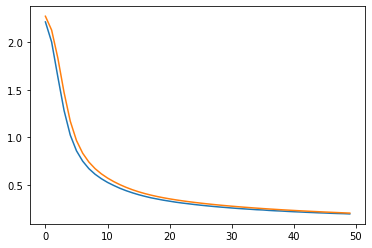

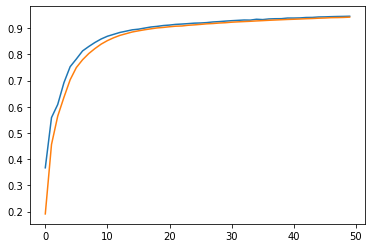

In [24]:
plt.plot(np.arange(50), history.history['val_loss'])
plt.plot(np.arange(50), history.history['loss'])
plt.show()
plt.plot(np.arange(50), history.history['val_accuracy'])
plt.plot(np.arange(50), history.history['accuracy'])
plt.show()